# Real-Time Data Extraction and Machine Learning for Optimized Uber Ride Booking using Continuous Learning

### Objective:
- The rise of ride-sharing services like Uber has transformed urban transportation. However, users often struggle with fluctuating ride prices and varying wait times. This project addresses these challenges by leveraging real-time data and machine learning models to predict the best times for booking Uber rides. The goal is to provide a data-driven approach that ensures cost savings and improved convenience for users.

### Project Scope and Applications:
- End-to-End Development: The project involves real-time data extraction, machine learning for fare prediction, waiting time, ride time and delivering results via a Streamlit application.
- Real-World Relevance: The system will optimize Uber ride booking by suggesting the cheapest fare times, potentially saving users money and time while constantly learning from new data.


#### This step comes after the creation and running of webscrapping in main.py (Data collection started from 2024-09-10 and is currently running still for 1 hour intervals between 7 am and 11 pm for 42 unique routes 

# 1.0 Setting up MySql Connection

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text

# Database connection parameters
username = 'root'
password = 'expert789'
host = 'localhost'
port = '3306'
database = 'uber'

# Create a database connection
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# Create a connection
with engine.connect() as connection:
    # Execute the query
    result = connection.execute(text("SELECT * FROM uber_details"))
    df = pd.DataFrame(result.fetchall(), columns=result.keys())


In [3]:

# Create a connection
with engine.connect() as connection:
    # Execute the query
    result = connection.execute(text("SELECT * FROM uber_details"))
    df = pd.DataFrame(result.fetchall(), columns=result.keys())


# 2.0 Exploratory Data Analysis

In [4]:
df

,id,route_from,route_to,ride_type,ride_max_persons,ride_request_time,ride_waiting_time,ride_request_date,ride_reaching_time,ride_time,ride_price
0,1,Chennai Lighthouse,Chennai Citi Centre,Uber Auto,3.0,16:34:22,2.0,2024-09-10,16:43:00,0:06:38,70.00
1,2,Chennai Lighthouse,Chennai Citi Centre,Uber Go,4.0,16:34:22,6.0,2024-09-10,16:48:00,0:07:38,138.07
2,3,Chennai Lighthouse,Chennai Citi Centre,Moto,1.0,16:34:22,6.0,2024-09-10,16:48:00,0:07:38,32.00
3,4,Chennai Lighthouse,Chennai Citi Centre,Premier,4.0,16:34:22,8.0,2024-09-10,16:50:00,0:07:38,207.76
4,5,Chennai Lighthouse,Chennai Citi Centre,Go Sedan,4.0,16:34:22,8.0,2024-09-10,16:49:00,0:06:38,147.06
...,...,...,...,...,...,...,...,...,...,...,...
23017,23018,Semmozhi Poonga,Marina Beach,Uber Go,4.0,13:06:11,2.0,2024-09-19,13:29:00,0:20:49,216.48
23018,23019,Semmozhi Poonga,Marina Beach,Moto,1.0,13:06:11,2.0,2024-09-19,13:27:00,0:18:49,52.24
23019,23020,Semmozhi Poonga,Marina Beach,Premier,4.0,13:06:11,3.0,2024-09-19,13:29:00,0:19:49,327.20
23020,23021,Semmozhi Poonga,Marina Beach,Go Sedan,4.0,13:06:11,3.0,2024-09-19,13:30:00,0:20:49,238.50


In [3]:
print(df['ride_request_date'].min())
print(df['ride_request_date'].max())


2024-09-10
2024-09-19


In [4]:
from summarytools import dfSummary

In [5]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 9396.5 (5424.9)min < med < max:1.0 < 9396.5 < 18792.0IQR (CV) : 9395.5 (1.7),"18,792 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3XQU7CYBBA4fkbJSCkDSHCAbwBSw7hYT0EJ2DhxhU7EtKUUDEarCcAKTXqS963baczixcSUtM0If132V8fIF3i5rsXUkqDiOhd+f0sIj6vnO06T91Nvbvr/HvTNIdTD8+GmlIaTCaTxzzPx223Ho/H27quH0aj0UuWZR+/OU/dTb37J+Z3u12ZUno6Fet3v6i9PM/Hi8XiUBTFW5vF6/V6vFqt7ufz+fNsNivbzHadp+6m3t11vqqq/nK5HG+3215EXBVqREQURfE2nU5f2ywvy3IQETEcDlvPdp2n7qbe/RPzETE499A/U0IwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEK4eaSl6qq6rf98H6/70dE1HXd32w2d785T91Nvbvr/CV9fQGSljnmc7n3zQAAAABJRU5ErkJggg=="">",0(0.0%)
2,route_from[object],1. Chennai Lighthouse2. Chennai Citi Centre3. PVR Ampa SkyOne4. Express Avenue Mall5. Marina Beach6. Semmozhi Poonga7. Sai Baba Temple Mylapore,"2,946 (15.7%)2,862 (15.2%)2,634 (14.0%)2,628 (14.0%)2,628 (14.0%)2,550 (13.6%)2,544 (13.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACjklEQVR4nO3bMWobUQBF0a8gTNxICIMX40VksVnE7EYITxEbN0qRyrbc6d8gfM4CRiouM8zw3+Z8Pg8o/Pjff4DvQ2xkxEZGbGTERmYzxrgfY9xN/I238/n8MvH63Ijtw8PDr91ud5j1A+u6njabzW/Bsd3tdoenp6eX/X7/eu2LPz8//1yW5XA8Hu/GGGL75rZjjLHf718fHx//TPqN+0nX5cZ4QSAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOzHePfUaAZF591XW7Tdl3X07IshzHpKNC6rqcxxtuMa3NbHAsns7GIp+LORsbghYzBCxmDFzI+6pIRGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxnrKjLWVWRsEMhYV5GZeWdzR+Odaesqqyo+mrKusqrikpnrKqsq3vFRl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcyUwYuhC5dMG7wYuvCRY+FkDF7IeEEg4zFKxrqKjHUVGesqMl4QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuNYOBnrKjLubGQMXsgYvJAxeCHjoy4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kHAsnY/BCxgsCmVmPUY9QPpmyrrKs4pKrr6ssq/jKrHWVZRWfeEEgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc/V1lWUVX5myrrKs4hLHwslYV5FxZyNj8ELG4IWMwQsZH3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MdRUZ6yoyNghkrKvIeEEgIzYyYiMjNjJ/AcSkeRXqQyZyAAAAAElFTkSuQmCC"">",0(0.0%)
3,route_to[object],1. Chennai Lighthouse2. Marina Beach3. PVR Ampa SkyOne4. Express Avenue Mall5. Sai Baba Temple Mylapore6. Semmozhi Poonga7. Chennai Citi Centre8. CitiCenter,"2,940 (15.6%)2,610 (13.9%)2,604 (13.9%)2,598 (13.8%)2,598 (13.8%)2,550 (13.6%)2,388 (12.7%)504 (2.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC+UlEQVR4nO3cMU4bUQBF0e/IQqGxZSGxGBaRxWYR3g1CTBEQjVOkMrap/G9kcc4CZiiuvjWjeawOh8OAwo///QfwfYiNjNjIiI2M2MiIjcxqjHE/xribeI+Pw+HwNvH63Ij1w8PDr81ms5t1g2VZXlar1W/Bsd5sNrunp6e37Xb7fu2Lv76+/tzv97vn5+e7MYbYvrn1GGNst9v3x8fHP5PucT/putwYDwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxk1mP8+xRoxsVnXZfbtF6W5WW/3+/GpE+BlmV5GWN8zLg2t8Vn4WRW/v0ClZknmxONI9MGL4YufDZl8GLowjkzBy+GLhzxUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MlMGLoQvnTBu8GLrwmc/CyRi8kPGAQGbWz6ifUE5MWVdZVnHO1ddVllVcMmtdZVnFCQ8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZK6+rrKs4pIp6yrLKs7xWTgZ6yoyTjYyBi9kDF7IGLyQ8VKXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGYMXMj4LJ2PwQsYDAhk/o2Ssq8hYV5GxriLjAYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MdRUZ6yoyPgsnY11FxslGxuCFjMELGYMXMl7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGesqMtZVZGwQyFhXkZlxsjnVOOvq6yrLKi656rrKsoqvzFhXWVZxlpe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZK46eDF24StXH7wYu3CJz8LJGLyQOXeyOZmY4mTwYrDCLEeDF4MVZjo3eDFYYQovdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczRuso6iplO1lXWUcxig0DGuoqMBwQyYiMjNjJiIyM2Mn8BFg6uhHpbwY4AAAAASUVORK5CYII="">",0(0.0%)
4,ride_type[object],1. Uber Auto2. Uber

In [6]:
df.head(1)

,id,route_from,route_to,ride_type,ride_max_persons,ride_request_time,ride_waiting_time,ride_request_date,ride_reaching_time,ride_time,ride_price
0,1,Chennai Lighthouse,Chennai Citi Centre,Uber Auto,3.0,16:34:22,2.0,2024-09-10,16:43:00,0:06:38,70.0


In [7]:
df.dtypes

id                      int64
route_from             object
route_to               object
ride_type              object
ride_max_persons      float64
ride_request_time      object
ride_waiting_time     float64
ride_request_date      object
ride_reaching_time     object
ride_time              object
ride_price            float64
dtype: object

# 3. Data Preprocessing

In [5]:
# Convert ride_request_time to proper datetime
df['ride_request_time'] = pd.to_datetime(df['ride_request_date'] + ' ' + df['ride_request_time'])

# Drop unnecessary columns
df = df.drop(columns=['id', 'ride_reaching_time'])

# Convert 'ride_time' to total seconds and then to minutes
df['ride_time_seconds'] = pd.to_timedelta(df['ride_time']).dt.total_seconds()
df['ride_time_minutes'] = df['ride_time_seconds'] / 60

# Create 'ride_time_request_clean' by rounding the ride_request_time to the nearest hour
df['ride_time_request_clean'] = df['ride_request_time'].dt.round('H').dt.time

# Group by 'route_from', 'route_to', 'ride_request_date', 'ride_time_request_clean', and 'ride_type'
grouped = df.groupby(['route_from', 'route_to', 'ride_request_date', 'ride_time_request_clean', 'ride_type'], as_index=False).agg({
    'ride_price': 'mean',
    'ride_max_persons': 'mean',
    'ride_waiting_time': 'mean',
    'ride_time_minutes': 'mean'  # Use ride_time_minutes for time-related calculations
})



/var/folders/ng/411k2bk11d540st5s0w7gdch0000gn/T/ipykernel_87732/3198539687.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['ride_time_request_clean'] = df['ride_request_time'].dt.round('H').dt.time


In [6]:
grouped

,route_from,route_to,ride_request_date,ride_time_request_clean,ride_type,ride_price,ride_max_persons,ride_waiting_time,ride_time_minutes
0,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Go Sedan,147.06,4.0,6.000000,7.983333
1,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Moto,35.416667,1.0,5.333333,7.983333
2,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Premier,199.183333,4.0,6.000000,8.316667
3,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Uber Auto,70.0,3.0,1.333333,7.650000
4,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Uber Go,143.01,4.0,6.000000,8.650000
...,...,...,...,...,...,...,...,...,...
21439,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Moto,56.33,1.0,2.000000,17.266667
21440,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Premier,304.01,4.0,3.000000,19.266667
21441,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Uber Auto,129.2,3.0,1.000000,18.266667
21442,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Uber Go,185.37,4.0,2.000000,20.266667


In [7]:
grouped.dtypes

route_from                  object
route_to                    object
ride_request_date           object
ride_time_request_clean     object
ride_type                   object
ride_price                  object
ride_max_persons           float64
ride_waiting_time          float64
ride_time_minutes          float64
dtype: object

In [8]:
# Convert 'ride_request_date' to datetime (date only)
grouped['ride_request_date'] = pd.to_datetime(grouped['ride_request_date'], format='%Y-%m-%d')

# Convert 'ride_time_request_clean' to a string (if it's not already)
grouped['ride_time_request_clean'] = grouped['ride_time_request_clean'].astype(str)

# Combine 'ride_request_date' and 'ride_time_request_clean'
grouped['ride_datetime'] = pd.to_datetime(grouped['ride_request_date'].astype(str) + ' ' + grouped['ride_time_request_clean'])

# Extract the hour from the combined datetime
grouped['hour'] = grouped['ride_datetime'].dt.hour
grouped['day_of_week'] = grouped['ride_datetime'].dt.dayofweek

In [9]:
grouped

,route_from,route_to,ride_request_date,ride_time_request_clean,ride_type,ride_price,ride_max_persons,ride_waiting_time,ride_time_minutes,ride_datetime,hour,day_of_week
0,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Go Sedan,147.06,4.0,6.000000,7.983333,2024-09-10 17:00:00,17,1
1,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Moto,35.416667,1.0,5.333333,7.983333,2024-09-10 17:00:00,17,1
2,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Premier,199.183333,4.0,6.000000,8.316667,2024-09-10 17:00:00,17,1
3,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Uber Auto,70.0,3.0,1.333333,7.650000,2024-09-10 17:00:00,17,1
4,Chennai Citi Centre,Chennai Lighthouse,2024-09-10,17:00:00,Uber Go,143.01,4.0,6.000000,8.650000,2024-09-10 17:00:00,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21439,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Moto,56.33,1.0,2.000000,17.266667,2024-09-19 13:00:00,13,3
21440,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Premier,304.01,4.0,3.000000,19.266667,2024-09-19 13:00:00,13,3
21441,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Uber Auto,129.2,3.0,1.000000,18.266667,2024-09-19 13:00:00,13,3
21442,Semmozhi Poonga,Sai Baba Temple Mylapore,2024-09-19,13:00:00,Uber Go,185.37,4.0,2.000000,20.266667,2024-09-19 13:00:00,13,3


In [10]:
# Load your cleaned dataset
df = pd.DataFrame(grouped)

In [11]:
df= df[['route_from','route_to','ride_type','ride_max_persons','hour','day_of_week','ride_waiting_time','ride_time_minutes','ride_price']]
df

,route_from,route_to,ride_type,ride_max_persons,hour,day_of_week,ride_waiting_time,ride_time_minutes,ride_price
0,Chennai Citi Centre,Chennai Lighthouse,Go Sedan,4.0,17,1,6.000000,7.983333,147.06
1,Chennai Citi Centre,Chennai Lighthouse,Moto,1.0,17,1,5.333333,7.983333,35.416667
2,Chennai Citi Centre,Chennai Lighthouse,Premier,4.0,17,1,6.000000,8.316667,199.183333
3,Chennai Citi Centre,Chennai Lighthouse,Uber Auto,3.0,17,1,1.333333,7.650000,70.0
4,Chennai Citi Centre,Chennai Lighthouse,Uber Go,4.0,17,1,6.000000,8.650000,143.01
...,...,...,...,...,...,...,...,...,...
21439,Semmozhi Poonga,Sai Baba Temple Mylapore,Moto,1.0,13,3,2.000000,17.266667,56.33
21440,Semmozhi Poonga,Sai Baba Temple Mylapore,Premier,4.0,13,3,3.000000,19.266667,304.01
21441,Semmozhi Poonga,Sai Baba Temple Mylapore,Uber Auto,3.0,13,3,1.000000,18.266667,129.2
21442,Semmozhi Poonga,Sai Baba Temple Mylapore,Uber Go,4.0,13,3,2.000000,20.266667,185.37


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

#1. Descriptive statistics
df.describe()

,ride_max_persons,hour,day_of_week,ride_waiting_time,ride_time_minutes
count,21444.000000,21444.000000,21444.000000,21444.000000,21444.000000
mean,3.666667,14.654729,2.671796,4.055019,18.326552
std,1.490747,4.761747,1.707197,2.306364,8.471841
min,1.000000,7.000000,0.000000,1.000000,4.750000
25%,3.000000,10.000000,2.000000,2.000000,12.700000
50%,4.000000,14.000000,2.000000,4.000000,15.766667
75%,4.000000,19.000000,4.000000,5.000000,22.533333
max,6.000000,23.000000,6.000000,13.000000,52.233333


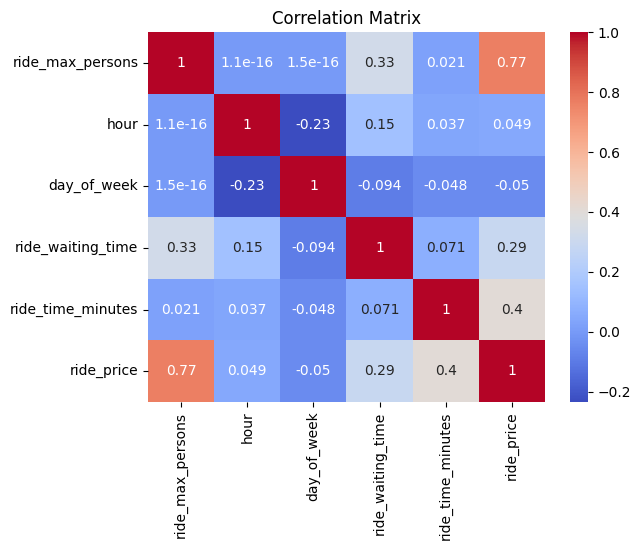

In [24]:
# 2. Correlation matrix
numericals= df[['ride_max_persons','hour','day_of_week','ride_waiting_time','ride_time_minutes','ride_price']]
correlation_matrix = numericals.corr()


# 3. Correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()


- Although hours, day of week likely affect the price, they are not totaly co-related as they are fluctions among them thus we don't need to drop any colums but proceed with next steps

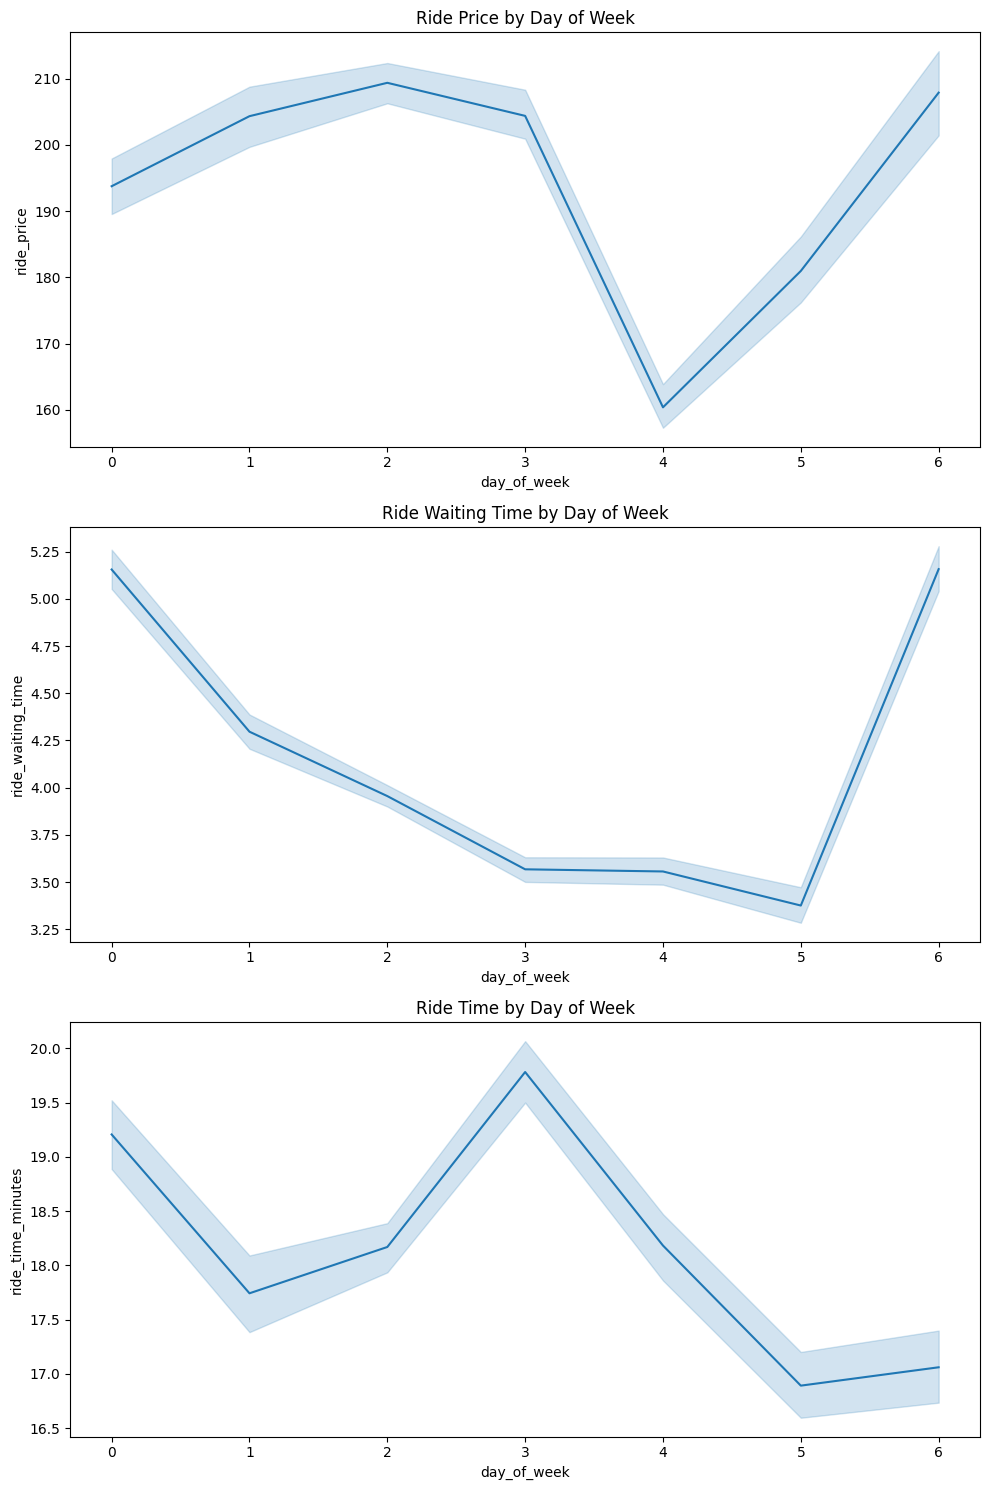

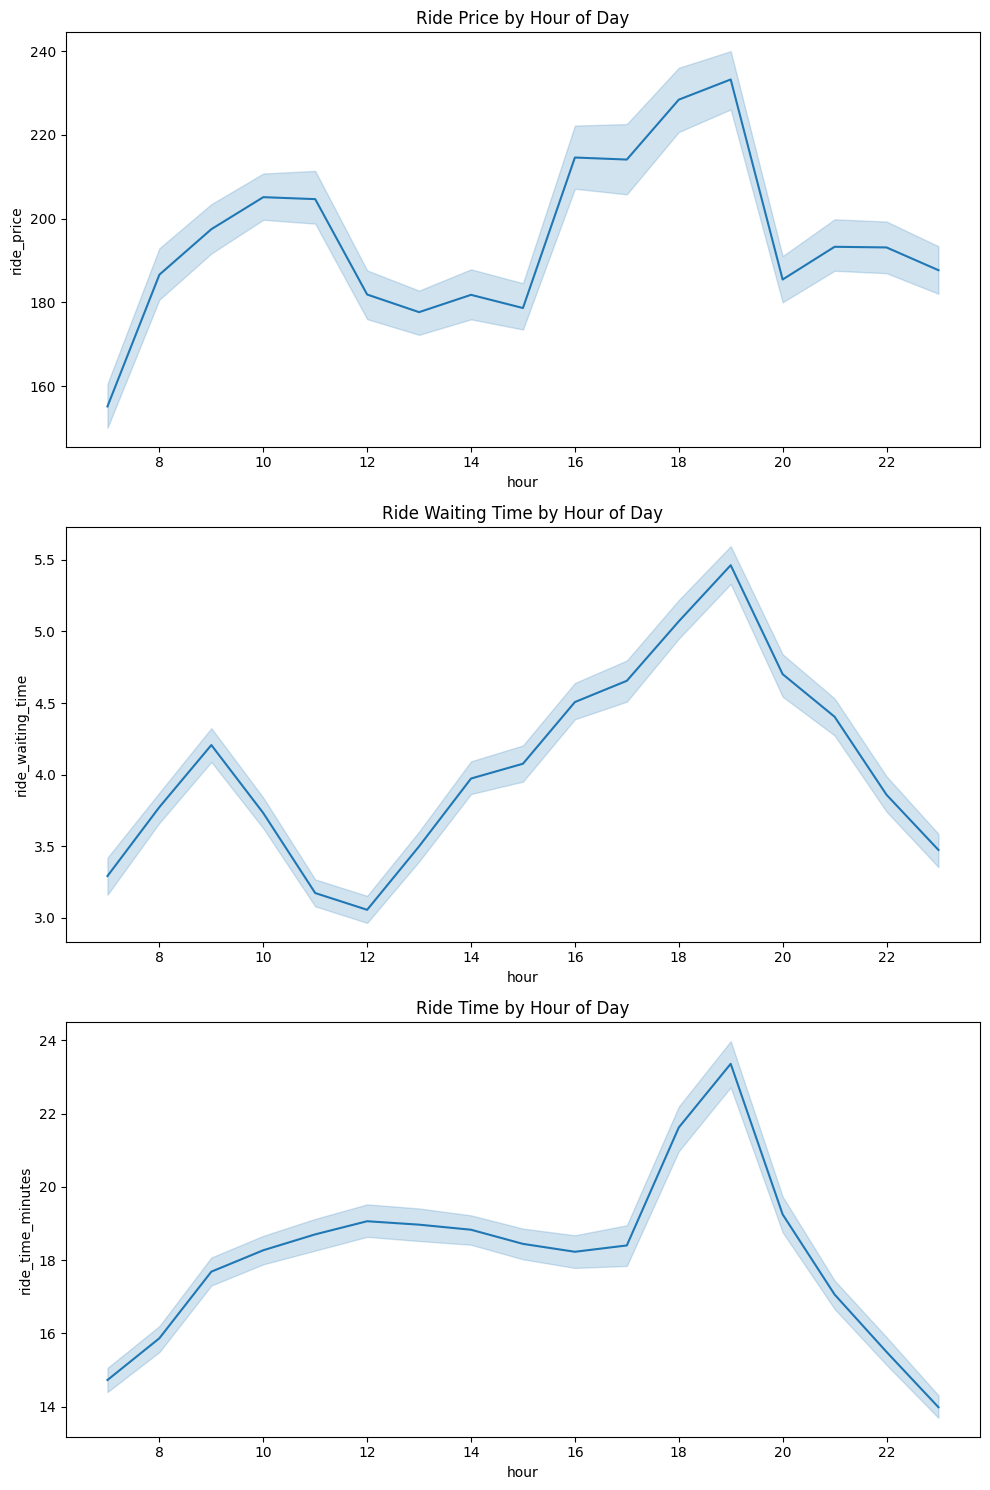

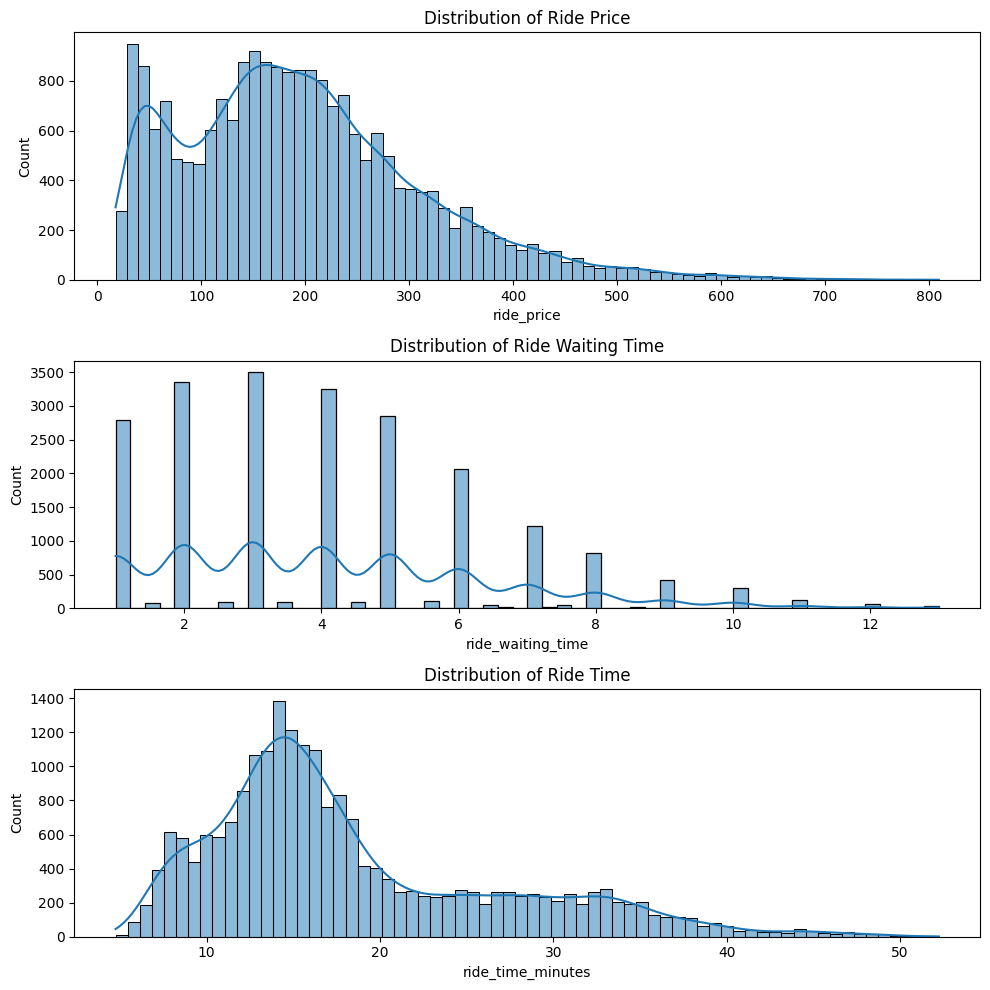

In [26]:
# 4. Line plots for day_of_week
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(x='day_of_week', y='ride_price', data=df, ax=axes[0])
axes[0].set_title('Ride Price by Day of Week')

sns.lineplot(x='day_of_week', y='ride_waiting_time', data=df, ax=axes[1])
axes[1].set_title('Ride Waiting Time by Day of Week')

sns.lineplot(x='day_of_week', y='ride_time_minutes', data=df, ax=axes[2])
axes[2].set_title('Ride Time by Day of Week')

plt.tight_layout()
plt.show()

# 5. Line plots for hour of the day
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(x='hour', y='ride_price', data=df, ax=axes[0])
axes[0].set_title('Ride Price by Hour of Day')

sns.lineplot(x='hour', y='ride_waiting_time', data=df, ax=axes[1])
axes[1].set_title('Ride Waiting Time by Hour of Day')

sns.lineplot(x='hour', y='ride_time_minutes', data=df, ax=axes[2])
axes[2].set_title('Ride Time by Hour of Day')

plt.tight_layout()
plt.show()

# 6. Distribution plots for numerical features
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

sns.histplot(df['ride_price'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Ride Price')

sns.histplot(df['ride_waiting_time'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Ride Waiting Time')

sns.histplot(df['ride_time_minutes'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Ride Time')

plt.tight_layout()
plt.show()


- Clearly fluctions among days of week and hours of day among all three variables (ride price, ride waiting time, and ride time)
- Variable are also not much skewed, so it shoud be okay for the machine learning models

# 4.0 Model Selection and Training

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming your DataFrame is already loaded into `df`

# Step 1: Split the data into features (X) and targets (y)
X = df.drop(columns=['ride_price', 'ride_waiting_time', 'ride_time_minutes'])
y_price = df['ride_price']
y_waiting_time = df['ride_waiting_time']
y_ride_time = df['ride_time_minutes']

# Step 2: Train-Test Split
X_train, X_test, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=42)
_, _, y_train_waiting, y_test_waiting = train_test_split(X, y_waiting_time, test_size=0.2, random_state=42)
_, _, y_train_time, y_test_time = train_test_split(X, y_ride_time, test_size=0.2, random_state=42)

# Define numerical and categorical columns
numerical_features = ['ride_max_persons', 'hour', 'day_of_week']
categorical_features = ['route_from', 'route_to', 'ride_type']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Step 3: Create pipelines for each target
price_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

waiting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

time_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Step 4: Fit the models
price_pipeline.fit(X_train, y_train_price)
waiting_pipeline.fit(X_train, y_train_waiting)
time_pipeline.fit(X_train, y_train_time)

# Step 5: Predict on the test data
price_predictions = price_pipeline.predict(X_test)
waiting_predictions = waiting_pipeline.predict(X_test)
time_predictions = time_pipeline.predict(X_test)

# Step 6: Evaluate the models
def evaluate_model(true, predicted, metric_name="Model"):
    print(f"--- {metric_name} ---")
    print("Mean Absolute Error (MAE):", mean_absolute_error(true, predicted))
    print("Mean Squared Error (MSE):", mean_squared_error(true, predicted))
    print("R² Score:", r2_score(true, predicted))
    print()

# Evaluate price prediction model
evaluate_model(y_test_price, price_predictions, "Random Forest Price Prediction Model")

# Evaluate waiting time prediction model
evaluate_model(y_test_waiting, waiting_predictions, "Random Forest Waiting Time Prediction Model")

# Evaluate ride time prediction model
evaluate_model(y_test_time, time_predictions, "Random Forest Ride Time Prediction Model")


--- Random Forest Price Prediction Model ---
Mean Absolute Error (MAE): 10.017634153005465
Mean Squared Error (MSE): 373.0349721128934
R² Score: 0.9688103596681626

--- Random Forest Waiting Time Prediction Model ---
Mean Absolute Error (MAE): 0.38259514907487296
Mean Squared Error (MSE): 0.39639956699581375
R² Score: 0.9291120850372716

--- Random Forest Ride Time Prediction Model ---
Mean Absolute Error (MAE): 0.6325770140286968
Mean Squared Error (MSE): 0.6675361321222005
R² Score: 0.9908885757758246



In [117]:
import xgboost as xgb

# Create pipelines for each target
xg_price_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

xg_waiting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

xg_time_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Step 4: Fit the models
xg_price_pipeline.fit(X_train, y_train_price)
xg_waiting_pipeline.fit(X_train, y_train_waiting)
xg_time_pipeline.fit(X_train, y_train_time)

# Step 5: Predict on the test data
price_predictions = xg_price_pipeline.predict(X_test)
waiting_predictions = xg_waiting_pipeline.predict(X_test)
time_predictions = xg_time_pipeline.predict(X_test)

# Step 6: Evaluate the models
def evaluate_model(true, predicted, metric_name="Model"):
    print(f"--- {metric_name} ---")
    print("Mean Absolute Error (MAE):", mean_absolute_error(true, predicted))
    print("Mean Squared Error (MSE):", mean_squared_error(true, predicted))
    print("R² Score:", r2_score(true, predicted))
    print()

# Evaluate price prediction model
evaluate_model(y_test_price, price_predictions, "XGBoost Price Prediction Model")

# Evaluate waiting time prediction model
evaluate_model(y_test_waiting, waiting_predictions, "XGBoost Waiting Time Prediction Model")

# Evaluate ride time prediction model
evaluate_model(y_test_time, time_predictions, "XGBoost Ride Time Prediction Model")


--- XGBoost Price Prediction Model ---
Mean Absolute Error (MAE): 10.102199054007942
Mean Squared Error (MSE): 314.7897112639407
R² Score: 0.9738134965006694

--- XGBoost Waiting Time Prediction Model ---
Mean Absolute Error (MAE): 0.6035203063037675
Mean Squared Error (MSE): 0.6893802861069517
R² Score: 0.8737852909955264

--- XGBoost Ride Time Prediction Model ---
Mean Absolute Error (MAE): 0.5865173989346546
Mean Squared Error (MSE): 0.6334017144045959
R² Score: 0.9914717533586962



In [118]:
from sklearn.linear_model import LinearRegression

# Create pipelines for each target
lr_price_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression()
)
])

lr_waiting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression()
)
])

lr_time_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression()
)
])

# Fit Linear Regression models
lr_price_pipeline.fit(X_train, y_train_price)
lr_waiting_pipeline.fit(X_train, y_train_waiting)
lr_time_pipeline.fit(X_train, y_train_time)

# Predict and evaluate Linear Regression models
price_lr_predictions = lr_price_pipeline.predict(X_test)
waiting_lr_predictions = lr_waiting_pipeline.predict(X_test)
time_lr_predictions = lr_time_pipeline.predict(X_test)

# Evaluate Linear Regression models
evaluate_model(y_test_price, price_lr_predictions, "Linear Regression Price Prediction Model")
evaluate_model(y_test_waiting, waiting_lr_predictions, "Linear Regression Waiting Time Prediction Model")
evaluate_model(y_test_time, time_lr_predictions, "Linear Regression Ride Time Prediction Model")


--- Linear Regression Price Prediction Model ---
Mean Absolute Error (MAE): 33.3068383392167
Mean Squared Error (MSE): 2298.816590761756
R² Score: 0.8087676739605123

--- Linear Regression Waiting Time Prediction Model ---
Mean Absolute Error (MAE): 1.3201258525689152
Mean Squared Error (MSE): 2.902264975361982
R² Score: 0.46864084061963085

--- Linear Regression Ride Time Prediction Model ---
Mean Absolute Error (MAE): 3.0053159556271702
Mean Squared Error (MSE): 16.92624728254662
R² Score: 0.7721016406263651



# 5.0 Hyperparameter tuning

In [126]:
## Random Forest Performs the best, performing hyper tuning to see best one

from sklearn.model_selection import RandomizedSearchCV

# Define parameter distributions
param_distributions = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
# Create RandomizedSearchCV objects with verbose parameter
price_random_search = RandomizedSearchCV(price_pipeline, param_distributions, n_iter=1, cv=2, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42, verbose=3)
waiting_random_search = RandomizedSearchCV(waiting_pipeline, param_distributions, n_iter=1, cv=2, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42, verbose=3)
time_random_search = RandomizedSearchCV(time_pipeline, param_distributions, n_iter=1, cv=2, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42, verbose=3)

# Fit RandomizedSearchCV objects
price_random_search.fit(X_train, y_train_price)
waiting_random_search.fit(X_train, y_train_waiting)
time_random_search.fit(X_train, y_train_time)

# Print best parameters and scores
print("Best parameters for price model:", price_random_search.best_params_)
print("Best score for price model:", -price_random_search.best_score_)
print("Best parameters for waiting time model:", waiting_random_search.best_params_)
print("Best score for waiting time model:", -waiting_random_search.best_score_)
print("Best parameters for ride time model:", time_random_search.best_params_)
print("Best score for ride time model:", -time_random_search.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters for price model: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
Best score for price model: 743.069685145743
Best parameters for waiting time model: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
Best score for waiting time model: 0.9187074325535796
Best parameters for ride time model: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
Best score for ride time model: 1.2271047220961067
[CV 1/2] END model__max_depth=20, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=200;, score=-744.120 total time=   3.2s
[CV 2/2] END model__max_depth=20, model__min_samples_leaf=4, model__min_

In [128]:
# Pipeline with best fit parameters
# Create pipelines for each targets
price_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, 
                                    min_samples_split =5,
                                    min_samples_leaf=4, 
                                    max_depth=20, 
                                    random_state=42))
])

waiting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, 
                                    min_samples_split =5,
                                    min_samples_leaf=4, 
                                    max_depth=20, 
                                    random_state=42))
])

time_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, 
                                    min_samples_split =5,
                                    min_samples_leaf=4, 
                                    max_depth=20, 
                                    random_state=42))
])

# Fit the models
price_pipeline.fit(X_train, y_train_price)
waiting_pipeline.fit(X_train, y_train_waiting)
time_pipeline.fit(X_train, y_train_time)

# Predict on the test data
price_predictions = price_pipeline.predict(X_test)
waiting_predictions = waiting_pipeline.predict(X_test)
time_predictions = time_pipeline.predict(X_test)

# Evaluate the models
def evaluate_model(true, predicted, metric_name="Model"):
    print(f"--- {metric_name} ---")
    print("Mean Absolute Error (MAE):", mean_absolute_error(true, predicted))
    print("Mean Squared Error (MSE):", mean_squared_error(true, predicted))
    print("R² Score:", r2_score(true, predicted))
    print()

# Evaluate price prediction model
evaluate_model(y_test_price, price_predictions, "Random Forest Price Prediction Model")

# Evaluate waiting time prediction model
evaluate_model(y_test_waiting, waiting_predictions, "Random Forest Waiting Time Prediction Model")

# Evaluate ride time prediction model
evaluate_model(y_test_time, time_predictions, "Random Forest Ride Time Prediction Model")


--- Random Forest Price Prediction Model ---
Mean Absolute Error (MAE): 12.658803162957074
Mean Squared Error (MSE): 543.8444256548307
R² Score: 0.9547590551853813

--- Random Forest Waiting Time Prediction Model ---
Mean Absolute Error (MAE): 0.536385676616281
Mean Squared Error (MSE): 0.6046137683109686
R² Score: 0.8893047098018871

--- Random Forest Ride Time Prediction Model ---
Mean Absolute Error (MAE): 0.7121654032193723
Mean Squared Error (MSE): 0.9006943062885056
R² Score: 0.9878728727476418



In [130]:
# Seems like the default parameters perform well on the test data, 
# so we will choose that 

In [131]:
# Let's save our model

Note: you may need to restart the kernel to use updated packages.


In [17]:
import joblib

# Save the pipelines
joblib.dump(price_pipeline, 'price_pipeline.pkl')
joblib.dump(waiting_pipeline, 'waiting_pipeline.pkl')
joblib.dump(time_pipeline, 'time_pipeline.pkl')


['time_pipeline.pkl']

In [22]:
df.to_csv('data/justadf.csv',index=False) #To get unique values for streamlit

# Now that model is selected and saved, we can go ahead and start creating our Streamlit Application